In [63]:
import json
import pickle
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

PassengerId | Survived | Pclass | Name | Sex | Age | SibSp | Parch | Ticket | Fare | Cabin | Embarked

In [64]:
# Load the dataset
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]
cols = ["SibSp", "Parch", "Fare", "Age"]

# Drop unused table fields
data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)
test = test.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)

# Fill nulls with the median
for col in cols:
    data[col].fillna(data[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)

data.Embarked.fillna("U", inplace=True) # U - unassigned 
test.Embarked.fillna("U", inplace=True) # U - unassigned 

In [65]:
# Encoding letters into the numbers

le = preprocessing.LabelEncoder()

cols = ["Sex", "Embarked"]

for col in cols:
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col])
    print(le.classes_)

['female' 'male']
['C' 'Q' 'S' 'U']


In [66]:
data.head(7)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
5,0,3,1,28.0,0,0,8.4583,1
6,0,1,1,54.0,0,0,51.8625,2


In [67]:
# Lock tables fields
X = data.iloc[:, :-1]
y = data['Survived']

# Split the dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# Train and evaluate the MLP classifier for different hidden layer sizes and learning rates

hidden_layer_sizes = [5, 10, 15, 20, 25, 30]
learning_rates = [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001]

results = []

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        
        for hls in hidden_layer_sizes:
            for lr in learning_rates:
                mlp = MLPClassifier(hidden_layer_sizes=(hls,), learning_rate_init=lr, max_iter=1000, random_state=18)
                mlp.fit(X_train_scaled, y_train)
                train_acc = accuracy_score(y_train, mlp.predict(X_train_scaled))
                test_acc = accuracy_score(y_test, mlp.predict(X_test_scaled))
                results.append((hls, lr, train_acc, test_acc))
except ConvergenceWarning:
    print('Convergence Warning Raised')

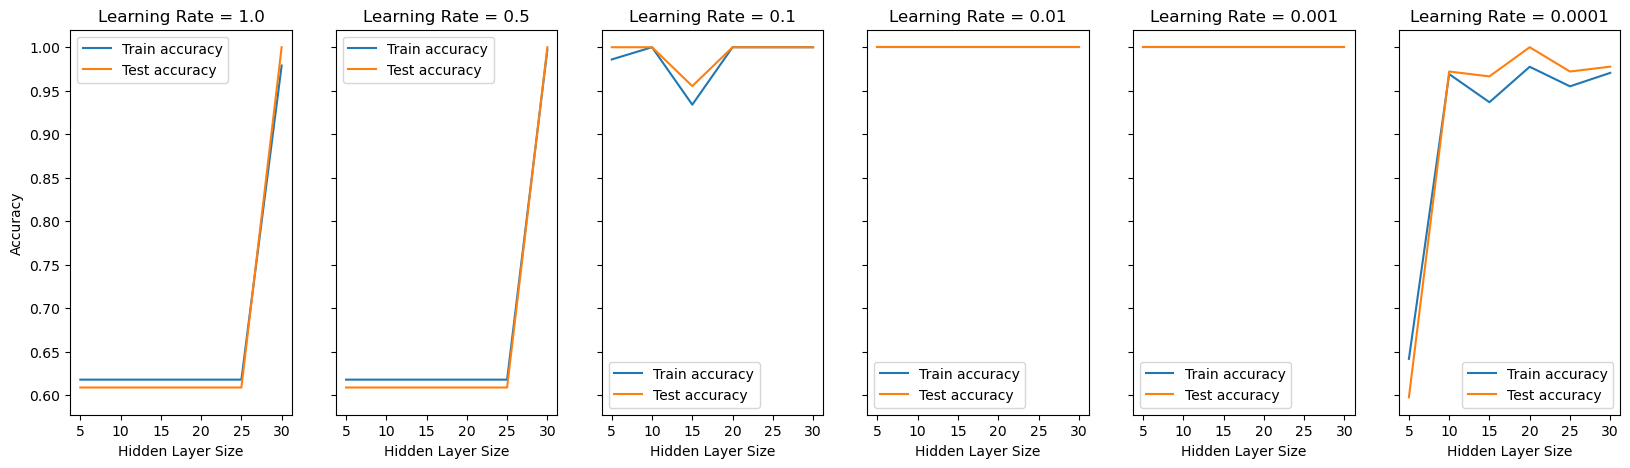

In [68]:
# Plot the results

fig, ax = plt.subplots(1, len(learning_rates), figsize=(20, 5), sharey=True)


for i, lr in enumerate(learning_rates):
    ax[i].plot(hidden_layer_sizes, [r[2] for r in results if r[1] == lr], label="Train accuracy")
    ax[i].plot(hidden_layer_sizes, [r[3] for r in results if r[1] == lr], label="Test accuracy")
    ax[i].set_title(f"Learning Rate = {lr}")
    ax[i].set_xlabel("Hidden Layer Size")
    ax[i].set_xticks(hidden_layer_sizes)
    ax[i].legend()

ax[0].set_ylabel("Accuracy")
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

# Find the best model
best_model = max(results, key=lambda x: x[3])
best_hls, best_lr = best_model[:2]

# Train the best model
best_mlp = MLPClassifier(hidden_layer_sizes=(best_hls,), learning_rate_init=best_lr, max_iter=1000, random_state=18)
best_mlp.fit(X_train_scaled, y_train)

predictions = best_mlp.predict(X_test)

print(accuracy_score(y_test, predictions))

0.5363128491620112


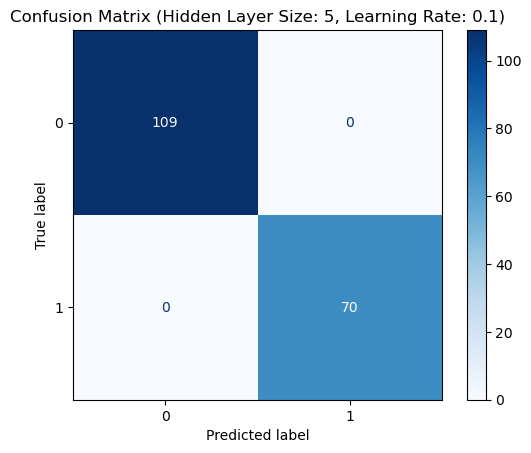

In [75]:
# Create and plot a confusion matrix

y_pred = best_mlp.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        plot_confusion_matrix(best_mlp, X_test_scaled, y_test, cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix (Hidden Layer Size: {best_hls}, Learning Rate: {best_lr})")
        plt.show()
except FutureWarning:
    print('Future Warning Raised')

In [71]:
# Save the model using pickle

filename = 'model.pkl'
pickle.dump(best_mlp, open(filename, 'wb'))

print("Model saved successfully.")

Model saved successfully.


In [72]:
# Creating submission table [FOR THE KAGGLE]

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        submission_preds = best_mlp.predict(test)
except FutureWarning:
    print('Future Warning Raised')

df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": submission_preds
                   })

df.to_csv("submission.csv", index=False)